In [11]:
from google.colab import drive
drive.mount('/content/drive')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: line 1: nvidia-smi: command not found
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 16.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import os
import random
from scipy import ndimage
# import SimpleITK as sitk
from os.path import join
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import skimage.transform  as sktf
import glob
# import numpy as np
import matplotlib.pyplot as plt

#CHIA TAP TRAIN - VAL - TEST
#NOTE: CHẠY 1 LẦN THUI

In [3]:
path_train_ct_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path_Liver/Train/ct.txt"
path_train_label_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path_Liver/Train/label.txt"

path_validate_ct_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path_Liver/Validate/ct.txt"
path_validate_label_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path_Liver/Validate/label.txt"

path_test_ct_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path_Liver/Test/ct.txt"
path_test_label_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path_Liver/Test/label.txt"

In [ ]:
path_train_list = []
path_train_mask_list = []

pathInputTarget = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_liver/train_val/ct/"
pathMaskTarget = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_liver/train_val/label/"
for instance_img in sorted(glob.iglob(pathInputTarget + "/*.npy")):
  path_train_list.append(instance_img)
  #print(instance_img)

for instance_mask in sorted(glob.iglob(pathMaskTarget + "/*.npy")):
  path_train_mask_list.append(instance_mask)
  #print(instance_mask)

In [ ]:
print(len(path_train_list))
print(len(path_train_mask_list))

19101
19101


In [ ]:
pathInputTarget = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_liver/test/ct/"
pathMaskTarget = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_liver/test/label/"
for instance_img in sorted(glob.iglob(pathInputTarget + "/*.npy")):
  path_train_list.append(instance_img)

for instance_mask in sorted(glob.iglob(pathMaskTarget + "/*.npy")):
  path_train_mask_list.append(instance_mask)

In [ ]:
print(len(path_train_list))
print(len(path_train_mask_list))

19101
19101


In [ ]:
from sklearn.model_selection import train_test_split
image_train, image_validate, mask_train, mask_validate = train_test_split(path_train_list, path_train_mask_list, test_size=0.2,random_state= 45)
image_validate, image_test, mask_validate, mask_test = train_test_split(image_validate, mask_validate, test_size=0.5,random_state= 45)

In [ ]:
print(len(image_train))
print(len(mask_train))

15280
15280


In [ ]:
print(len(image_validate))
print(len(mask_validate))

1910
1910


In [ ]:
print(len(image_test))
print(len(mask_test))

1911
1911


In [ ]:
# #for ct training dataset and label training
# with open(path_train_ct_txt, "w") as output:
#     strr =""
#     for index in range(len(image_train)):
#         if(index != (len(image_train)-1)):
#           strr = image_train[index] +","
#         else:
#           strr = image_train[index]
#         output.write(strr)


# with open(path_train_label_txt, "w") as output:
#     strr =""
#     for index in range(len(mask_train)):
#       if(index != (len(mask_train)-1)):
#         strr = mask_train[index] +","
#       else:
#         strr = mask_train[index]
#       output.write(strr)

In [ ]:
# # for ct validate dataset and label validate
# with open(path_validate_ct_txt, "w") as output:
#     strr =""
#     for index in range(len(image_validate)):
#         if(index != (len(image_validate)-1)):
#           strr = image_validate[index] +","
#         else:
#           strr = image_validate[index]
#         output.write(strr)


# with open(path_validate_label_txt, "w") as output:
#     strr =""
#     for index in range(len(mask_validate)):
#         if(index != (len(mask_validate)-1)):
#           strr = mask_validate[index] +","
#         else:
#           strr = mask_validate[index]
#         output.write(strr)

In [ ]:
# # for ct test dataset and label test
# with open(path_test_ct_txt, "w") as output:
#     strr =""
#     for index in range(len(image_test)):
#         if(index != (len(image_test)-1)):
#           strr = image_test[index] +","
#         else:
#           strr = image_test[index]
#         output.write(strr)


# with open(path_test_label_txt, "w") as output:
#     strr =""
#     for index in range(len(mask_test)):
#         if(index != (len(mask_test)-1)):
#           strr = mask_test[index] +","
#         else:
#           strr = mask_test[index]
#         output.write(strr)

In [ ]:
class LITS_slicing_train_val:
    def __init__(self, raw_dataset_root_path,slice_dataset_root_path):
        self.raw_dataset_root_path = raw_dataset_root_path
        self.slice_dataset_root_path = slice_dataset_root_path
        self.valid_rate = 0.2
        self.fillters = 20
        self.rs_shape = (128,128,1)
        self.tumor_label = True
        self.upper = 200
        self.lower = -200
        self.xy_down_scale = 0.25
        self.slice_down_scale = 1
        self.expand_slice = 20
        self.size = 48

    def slice_data(self):
        if not os.path.exists(self.slice_dataset_root_path):
            os.makedirs(join(self.slice_dataset_root_path,'ct'))
            os.makedirs(join(self.slice_dataset_root_path, 'label'))

        file_list = sorted(os.listdir(join(self.raw_dataset_root_path,'ct')))
        file_list = file_list[1:]
        Numbers = len(file_list)
        print('Total numbers of samples is :',Numbers)
        for ct_file,i in zip(file_list,range(Numbers)):
            print("********* {} | {}/{} *********".format(ct_file, i+1,Numbers))
            ct_path = os.path.join(self.raw_dataset_root_path, 'ct', ct_file)
            seg_path = os.path.join(self.raw_dataset_root_path, 'label', ct_file.replace('volume', 'segmentation'))
            self.process(ct_file, ct_path, seg_path, self.rs_shape)

    def process(self, ct_file, ct_path, seg_path, rs_shape):
        ct = sitk.ReadImage(ct_path, sitk.sitkInt16)
        ct_array = sitk.GetArrayFromImage(ct)
        seg = sitk.ReadImage(seg_path, sitk.sitkInt8)
        seg_array = sitk.GetArrayFromImage(seg)
        print("Ori shape:",ct_array.shape, seg_array.shape)

        if self.tumor_label:
            seg_array[seg_array < 1] = 0
            seg_array[seg_array >= 1] = 1

        ct_array[ct_array > self.upper] = self.upper
        ct_array[ct_array < self.lower] = self.lower

        z = np.any(seg_array, axis=(1, 2))
        print(z.shape)
        try:
            start_slice, end_slice = np.where(z)[0][[0, -1]]
        except:
            print ("Don't have tumor at this volume")
            return

        if start_slice - self.expand_slice < 0:
            start_slice = 0
        else:
            start_slice -= self.expand_slice

        if end_slice + self.expand_slice >= seg_array.shape[0]:
            end_slice = seg_array.shape[0] - 1
        else:
            end_slice += self.expand_slice

        print("Cut out range:",str(start_slice) + '--' + str(end_slice))
        if end_slice - start_slice + 1 < self.size:
            print('Too little slice，give up the sample:', ct_path)
            return None,None

        ct_array = ct_array[start_slice:end_slice + 1, :, :]
        # ct_slice = ct_array[85,:,:]
        # np.save('test.npy', ct_slice)
        seg_array = seg_array[start_slice:end_slice + 1, :, :]

        print("Preprocessed shape:",ct_array.shape,seg_array.shape)
        new_ct = sitk.GetImageFromArray(ct_array)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        # print(ct.GetSpacing())
        # new_ct.SetSpacing((ct.GetSpacing()[0] * int(1 / self.xy_down_scale), ct.GetSpacing()[1] * int(1 / self.xy_down_scale), self.slice_down_scale))
        # print(new_ct.GetSpacing())

        new_seg = sitk.GetImageFromArray(seg_array)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        # new_seg.SetSpacing((ct.GetSpacing()[0] * int(1 / self.xy_down_scale), ct.GetSpacing()[1] * int(1 / self.xy_down_scale), self.slice_down_scale))
        sum_tumor_pixel = 0
        num_slice = 0
        ct_array = sitk.GetArrayFromImage(new_ct)
        deep_ct_array = ct_array.shape[0]

        seg_array = sitk.GetArrayFromImage(new_seg)
        deep_seg_array = seg_array.shape[0]

        print("Ori shape volume after filter:",ct_array.shape, seg_array.shape)
        print("Ori deep volume after filter:",deep_ct_array, deep_seg_array)

        for i in range(0, deep_ct_array):
            sum_tumor_pixel = np.sum(seg_array[i,:,:] > 0)
            print("==== sum_tumor_pixel of slice {} of {} = {} ====".format(i, ct_file, sum_tumor_pixel))
            if(sum_tumor_pixel < self.fillters):
                continue
            else:
                print("==== slicing {} | {}/{} ====".format(ct_file, num_slice, deep_seg_array))
                ct_rs = sktf.resize(ct_array[i,:,:], rs_shape, mode = 'constant', preserve_range = True)
                ct_rs = (ct_rs - ct_rs.min())/((ct_rs.max()-ct_rs.min()))
                ct_rs = ct_rs.astype(np.float32)

                label_rs = sktf.resize(seg_array[i,:,:], rs_shape, mode = 'constant', preserve_range = True)
                label_rs = label_rs > 0.5
                label_rs = label_rs.astype(np.float32)
                path_slice_ct = os.path.join(self.slice_dataset_root_path, 'ct', ct_file.replace('.nii', f"_slice_{num_slice}.npy"))
                path_slice_label = os.path.join(self.slice_dataset_root_path, 'label', ct_file.replace('volume', 'segmentation').replace('.nii', f"_slice_{num_slice}.npy"))
                np.save(path_slice_ct, ct_rs)
                print("slice ct shape:",ct_rs.shape)
                np.save(path_slice_label, label_rs)
                print("slice label shape:", label_rs.shape)
                num_slice += 1

    def count_num_slice(self):
        slice_name_list_ct = os.listdir(join(self.slice_dataset_root_path, "ct"))
        slice_num = len(slice_name_list_ct)
        print('the sliced total numbers of samples ct is :', slice_num)
        slice_name_list_label = os.listdir(join(self.slice_dataset_root_path, "label"))
        slice_num = len(slice_name_list_label)
        print('the sliced total numbers of samples label is :', slice_num)

In [ ]:
#main
raw_dataset_root_path = '/content/drive/MyDrive/Liver Segmentation/Data/raw_dataset/train_val/'
slice_dataset_root_path = '/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_liver/train_val/'

tool = LITS_slicing_train_val(raw_dataset_root_path,slice_dataset_root_path)
tool.slice_data()
tool.count_num_slice()

Streaming output truncated to the last 5000 lines.
slice label shape: (128, 128, 1)
==== sum_tumor_pixel of slice 82 of volume-95.nii = 7248 ====
==== slicing volume-95.nii | 62/303 ====
slice ct shape: (128, 128, 1)
slice label shape: (128, 128, 1)
==== sum_tumor_pixel of slice 83 of volume-95.nii = 7273 ====
==== slicing volume-95.nii | 63/303 ====
slice ct shape: (128, 128, 1)
slice label shape: (128, 128, 1)
==== sum_tumor_pixel of slice 84 of volume-95.nii = 7328 ====
==== slicing volume-95.nii | 64/303 ====
slice ct shape: (128, 128, 1)
slice label shape: (128, 128, 1)
==== sum_tumor_pixel of slice 85 of volume-95.nii = 7363 ====
==== slicing volume-95.nii | 65/303 ====
slice ct shape: (128, 128, 1)
slice label shape: (128, 128, 1)
==== sum_tumor_pixel of slice 86 of volume-95.nii = 7385 ====
==== slicing volume-95.nii | 66/303 ====
slice ct shape: (128, 128, 1)
slice label shape: (128, 128, 1)
==== sum_tumor_pixel of slice 87 of volume-95.nii = 7587 ====
==== slicing volume-95.n

In [ ]:
#main
raw_dataset_root_path = '/content/drive/MyDrive/Liver Segmentation/Data/raw_dataset/train_val'
slice_dataset_root_path = '/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_liver/train_val'

tool = LITS_slicing_train_val(raw_dataset_root_path,slice_dataset_root_path)
# tool.slice_data()
tool.count_num_slice()

the sliced total numbers of samples ct is : 16914
the sliced total numbers of samples label is : 16914


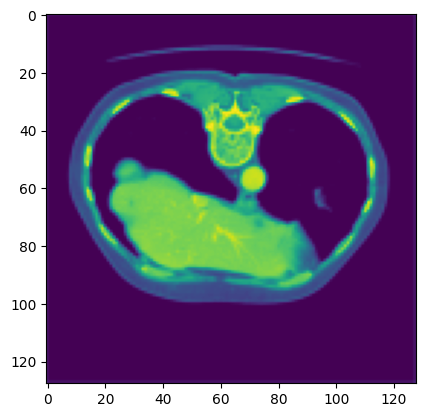

In [ ]:
im = np.load("/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_128_new_liver/train_val/ct/volume-0_slice_24.npy")
plt.imshow(im)

In [ ]:
class LITS_slicing_test:
    def __init__(self, raw_dataset_root_path,slice_dataset_root_path):
        self.raw_dataset_root_path = raw_dataset_root_path
        self.slice_dataset_root_path = slice_dataset_root_path
        self.valid_rate = 0.2
        self.fillters = 20
        self.rs_shape = (128,128,1)
        self.tumor_label = True
        self.upper = 200
        self.lower = -200
        self.xy_down_scale = 0.25
        self.slice_down_scale = 1
        self.expand_slice = 20
        self.size = 48

    def slice_data(self):
        if not os.path.exists(self.slice_dataset_root_path):
            os.makedirs(join(self.slice_dataset_root_path,'ct'))
            os.makedirs(join(self.slice_dataset_root_path, 'label'))

        file_list = sorted(os.listdir(join(self.raw_dataset_root_path,'ct')))
        # file_list = ['volume-0.nii']
        Numbers = len(file_list)
        print('Total numbers of samples is :',Numbers)
        for ct_file,i in zip(file_list,range(Numbers)):
            print("********* {} | {}/{} *********".format(ct_file, i+1,Numbers))
            ct_path = os.path.join(self.raw_dataset_root_path, 'ct', ct_file)
            seg_path = os.path.join(self.raw_dataset_root_path, 'label', ct_file.replace('volume', 'segmentation'))
            self.process(ct_file, ct_path, seg_path, self.rs_shape)

    def process(self, ct_file, ct_path, seg_path, rs_shape):
        ct = sitk.ReadImage(ct_path, sitk.sitkInt16)
        ct_array = sitk.GetArrayFromImage(ct)
        seg = sitk.ReadImage(seg_path, sitk.sitkInt8)
        seg_array = sitk.GetArrayFromImage(seg)
        print("Ori shape:",ct_array.shape, seg_array.shape)

        if self.tumor_label:
            seg_array[seg_array < 1] = 0
            seg_array[seg_array >= 1] = 1

        ct_array[ct_array > self.upper] = self.upper
        ct_array[ct_array < self.lower] = self.lower

        z = np.any(seg_array, axis=(1, 2))
        print(z.shape)
        try:
            start_slice, end_slice = np.where(z)[0][[0, -1]]
        except:
            print ("Don't have tumor at this volume")
            return

        if start_slice - self.expand_slice < 0:
            start_slice = 0
        else:
            start_slice -= self.expand_slice

        if end_slice + self.expand_slice >= seg_array.shape[0]:
            end_slice = seg_array.shape[0] - 1
        else:
            end_slice += self.expand_slice

        print("Cut out range:",str(start_slice) + '--' + str(end_slice))
        if end_slice - start_slice + 1 < self.size:
            print('Too little slice，give up the sample:', ct_path)
            return None,None

        ct_array = ct_array[start_slice:end_slice + 1, :, :]
        # ct_slice = ct_array[85,:,:]
        # np.save('test.npy', ct_slice)
        seg_array = seg_array[start_slice:end_slice + 1, :, :]

        print("Preprocessed shape:",ct_array.shape,seg_array.shape)
        new_ct = sitk.GetImageFromArray(ct_array)
        new_ct.SetDirection(ct.GetDirection())
        new_ct.SetOrigin(ct.GetOrigin())
        # print(ct.GetSpacing())
        # new_ct.SetSpacing((ct.GetSpacing()[0] * int(1 / self.xy_down_scale), ct.GetSpacing()[1] * int(1 / self.xy_down_scale), self.slice_down_scale))
        # print(new_ct.GetSpacing())

        new_seg = sitk.GetImageFromArray(seg_array)
        new_seg.SetDirection(ct.GetDirection())
        new_seg.SetOrigin(ct.GetOrigin())
        # new_seg.SetSpacing((ct.GetSpacing()[0] * int(1 / self.xy_down_scale), ct.GetSpacing()[1] * int(1 / self.xy_down_scale), self.slice_down_scale))
        sum_tumor_pixel = 0
        num_slice = 0
        ct_array = sitk.GetArrayFromImage(new_ct)
        deep_ct_array = ct_array.shape[0]

        seg_array = sitk.GetArrayFromImage(new_seg)
        deep_seg_array = seg_array.shape[0]

        print("Ori shape volume after filter:",ct_array.shape, seg_array.shape)
        print("Ori deep volume after filter:",deep_ct_array, deep_seg_array)

        for i in range(0, deep_ct_array):
            sum_tumor_pixel = np.sum(seg_array[i,:,:] > 0)
            print("==== sum_tumor_pixel of slice {} of {} = {} ====".format(i, ct_file, sum_tumor_pixel))
            if(sum_tumor_pixel < self.fillters):
                continue
            else:
                print("==== slicing {} | {}/{} ====".format(ct_file, num_slice, deep_seg_array))
                ct_rs = sktf.resize(ct_array[i,:,:], rs_shape, mode = 'constant', preserve_range = True)
                ct_rs = (ct_rs - ct_rs.min())/((ct_rs.max()-ct_rs.min()))
                ct_rs = ct_rs.astype(np.float32)

                label_rs = sktf.resize(seg_array[i,:,:], rs_shape, mode = 'constant', preserve_range = True)
                label_rs = label_rs > 0.5
                label_rs = label_rs.astype(np.float32)
                path_slice_ct = os.path.join(self.slice_dataset_root_path, 'ct', ct_file.replace('.nii', f"_slice_{num_slice}.npy"))
                path_slice_label = os.path.join(self.slice_dataset_root_path, 'label', ct_file.replace('volume', 'segmentation').replace('.nii', f"_slice_{num_slice}.npy"))
                np.save(path_slice_ct, ct_rs)
                print("slice ct shape:",ct_rs.shape)
                np.save(path_slice_label, label_rs)
                print("slice label shape:", label_rs.shape)
                num_slice += 1

    def count_num_slice(self):
        slice_name_list_ct = os.listdir(join(self.slice_dataset_root_path, "ct"))
        slice_num = len(slice_name_list_ct)
        print('the sliced total numbers of samples ct is :', slice_num)
        slice_name_list_label = os.listdir(join(self.slice_dataset_root_path, "label"))
        slice_num = len(slice_name_list_label)
        print('the sliced total numbers of samples label is :', slice_num)

In [ ]:
#main
raw_dataset_root_path = '/content/drive/MyDrive/Liver Segmentation/Data/raw_dataset/test/'
slice_dataset_root_path = '/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_liver/test/'

tool2 = LITS_slicing_test(raw_dataset_root_path,slice_dataset_root_path)
tool2.slice_data()
tool2.count_num_slice()

Streaming output truncated to the last 5000 lines.
==== slicing volume-35.nii | 98/124 ====
slice ct shape: (128, 128, 1)
slice label shape: (128, 128, 1)
==== sum_tumor_pixel of slice 105 of volume-35.nii = 45916 ====
==== slicing volume-35.nii | 99/124 ====
slice ct shape: (128, 128, 1)
slice label shape: (128, 128, 1)
==== sum_tumor_pixel of slice 106 of volume-35.nii = 44932 ====
==== slicing volume-35.nii | 100/124 ====
slice ct shape: (128, 128, 1)
slice label shape: (128, 128, 1)
==== sum_tumor_pixel of slice 107 of volume-35.nii = 44179 ====
==== slicing volume-35.nii | 101/124 ====
slice ct shape: (128, 128, 1)
slice label shape: (128, 128, 1)
==== sum_tumor_pixel of slice 108 of volume-35.nii = 42568 ====
==== slicing volume-35.nii | 102/124 ====
slice ct shape: (128, 128, 1)
slice label shape: (128, 128, 1)
==== sum_tumor_pixel of slice 109 of volume-35.nii = 39790 ====
==== slicing volume-35.nii | 103/124 ====
slice ct shape: (128, 128, 1)
slice label shape: (128, 128, 1)
=

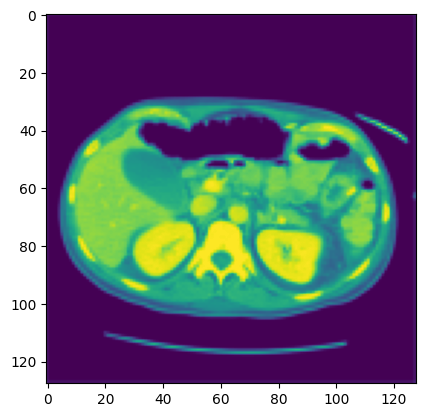

In [ ]:
im = np.load('/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_liver/train_val/ct/volume-55_slice_40.npy')
plt.imshow(im)

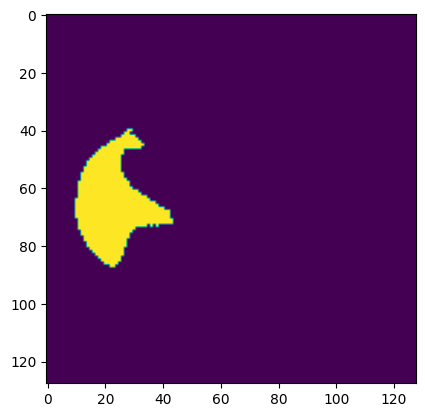

In [ ]:
im = np.load('/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_liver/train_val/label/segmentation-55_slice_40.npy')
plt.imshow(im)

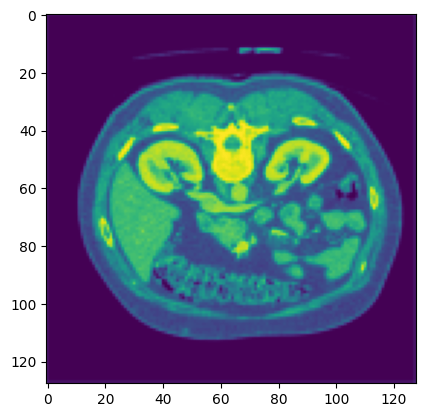

In [ ]:
im = np.load('/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_128_new_liver/test/ct/volume-32_slice_31.npy')
plt.imshow(im)

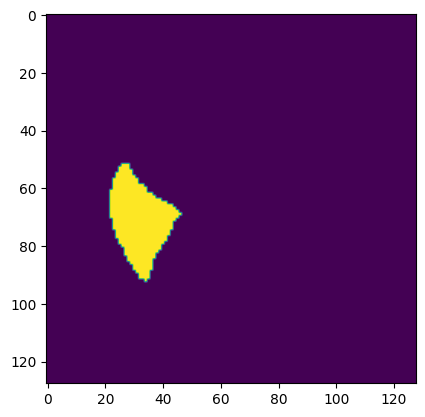

In [ ]:
im = np.load('/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_128_new_liver/test/label/segmentation-32_slice_31.npy')
plt.imshow(im)

In [20]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.3 MB/s eta 0:00:00


In [12]:
path_test_ct_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path_Liver/Test/ct.txt"
path_test_label_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path_Liver/Test/label.txt"

In [13]:
# for read ct test data and label training
image_test = []
with open(path_test_ct_txt, "r") as input:
    image_test = input.read().split(',')

In [14]:
# for read ct training dataset and label training
mask_test = []
with open(path_test_label_txt, "r") as input:
    mask_test = input.read().split(',')

In [15]:
def load_from_directory_label(image_mask):
    imgs = []
    print(len(image_mask))
    for i in range(0, len(image_mask)):
        img = np.load(image_mask[i])
        # img = np.expand_dims(img, axis = -1)
        imgs.append(img)
    return np.array(imgs)

In [16]:
def load_from_directory_ct(image_test):
    imgs = []
    print(len(image_test))
    for i in range(0, len(image_test)):
        img = np.load(image_test[i])
        # img = np.expand_dims(img, axis = -1)
        imgs.append(img)
    return np.array(imgs)

In [17]:
X = []
Y = []
image_test = image_test[1:10]
mask_test = mask_test[1:10]
X = load_from_directory_ct(image_test)
Y = load_from_directory_label(mask_test)

9
9


In [18]:
print(X.shape)

(9, 128, 128, 1)


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_addons as tfa
from tensorflow.keras import backend as K
from skimage.color import label2rgb
def visualize_segmentation(X,Y,num_samples=10,seed=None, subfig_size = 5):
    if seed is not None:
        np.random.seed(seed)
    metric = tfa.metrics.F1Score(1,average='micro',threshold=0.5)
    ridx = np.random.choice(X.shape[0],num_samples,False)
    im = X[ridx][:,:,:,0]
    mk = Y[ridx][:,:,:,0]

    fig,axes = plt.subplots(
        nrows=2,
        ncols=4,
        figsize=(subfig_size*4,subfig_size*2),
    )
    # if num_samples < 2:
    #     for ax, col in zip(axes, ['Img', 'Ground Truth']):
    #         ax.set_title(col)
    # else:
    #     for ax, col in zip(axes[0], ['Img', 'Ground Truth']):
    #         ax.set_title(col)

    for i in range(2):
      if i == 0:
        for j in range(4):
          axes[i][j].imshow(im[j])
          axes[i][j].set(xticks=[], yticks=[])
      if i == 1:
        for j in range(4):
          axes[i][j].imshow(label2rgb(mk[j],im[j], colors=['yellow',], alpha=1, bg_label=0, bg_color=None))
          axes[i][j].set(xticks=[], yticks=[])

    # for i,(ax1,ax2, ax3, ax4) in enumerate(axes):
    #   print(i)
    #   if i == 0:
    #     ax1.imshow(im[0])
    #     ax1.set(xticks=[], yticks=[])
    #     ax2.imshow(im[1])
    #     ax2.set(xticks=[], yticks=[])
    #     ax3.imshow(im[2])
    #     ax3.set(xticks=[], yticks=[])
    #     ax4.imshow(im[3])
    #     ax4.set(xticks=[], yticks=[])
    #   else:
    #     ax1.imshow(label2rgb(mk[0],im[0], colors=['yellow',], alpha=1, bg_label=0, bg_color=None))
    #     ax1.set(xticks=[], yticks=[])
    #     ax2.imshow(label2rgb(mk[1],im[1], colors=['yellow',], alpha=1, bg_label=0, bg_color=None))
    #     ax2.set(xticks=[], yticks=[])
    #     ax3.imshow(label2rgb(mk[2],im[2], colors=['yellow',], alpha=1, bg_label=0, bg_color=None))
    #     ax3.set(xticks=[], yticks=[])
    #     ax4.imshow(label2rgb(mk[3],im[3], colors=['yellow',], alpha=1, bg_label=0, bg_color=None))
    #     ax4.set(xticks=[], yticks=[])
    # plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.show()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


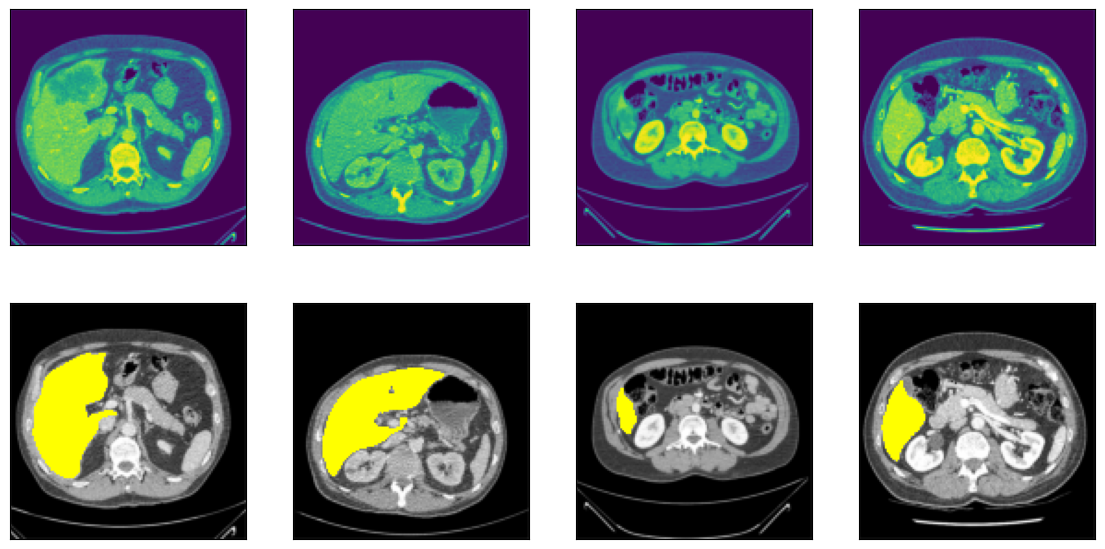

In [22]:
visualize_segmentation(
    X=X,
    Y=Y,
    num_samples=4,
    seed=45,
    subfig_size=3.5
)